In [2]:
import pandas as pd

In [139]:
recent_df = pd.read_excel('AI需要予測送付用 (9).xlsx', sheet_name='Sheet1')

In [4]:
import pandas as pd
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred, freq='W', start_date="2022-01-20"):
    """
    Calculate MAPE for aggregated time intervals (weekly, daily, monthly, etc.).
    
    Parameters:
    - y_true: list or array of true values.
    - y_pred: list or array of predicted values.
    - freq: str, frequency for aggregation ('W', 'D', 'M', etc.).
    - start_date: str, start date for the time index.
    
    Returns:
    - mape: float, Mean Absolute Percentage Error.
    - aggregated_df: DataFrame, aggregated y_true and y_pred.
    - absolute_error_rate: Series, absolute error rates for each period.
    """
    # インデックスとして日付を生成
    dates = pd.date_range(start=start_date, periods=len(y_true), freq="D")
    
    # DataFrameに変換
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    }, index=dates)
    
    # NaNと0を1に変換
    df = df.fillna(1).replace(0, 1)
    
    # 指定された頻度で集計
    aggregated_df = df.resample(freq).sum()
    
    # MAPE計算前の絶対誤差率
    absolute_error_rate = np.abs((aggregated_df['y_true'] - aggregated_df['y_pred']) / aggregated_df['y_true']) * 100
    
    # MAPEの計算
    mape = np.mean(absolute_error_rate)
    
    return mape, aggregated_df, absolute_error_rate


import pandas as pd
import numpy as np

def calculate_normalized_absolute_error(y_true, y_pred, freq='W', start_date="2024-01-20"):
    """
    Calculate Normalized Absolute Error for aggregated time intervals (weekly, daily, monthly, etc.).
    
    Parameters:
    - y_true: list or array of true values.
    - y_pred: list or array of predicted values.
    - freq: str, frequency for aggregation ('W', 'D', 'M', etc.).
    - start_date: str, start date for the time index.
    
    Returns:
    - nae: float, Normalized Absolute Error.
    - aggregated_df: DataFrame, aggregated y_true and y_pred.
    - absolute_error_rate: Series, absolute error rates for each period.
    """
    # インデックスとして日付を生成
    dates = pd.date_range(start=start_date, periods=len(y_true), freq="D")
    
    # DataFrameに変換
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    }, index=dates)
    
    # y_trueのNaNを0に置き換え
    df["y_true"] = df["y_true"].fillna(0.0)
    
    # y_predのNaNを0に置き換え
    df["y_pred"] = df["y_pred"].fillna(0.0)
    
    # 指定された頻度で集計
    aggregated_df = df.resample(freq).sum()
    
    # skip this
    absolute_error_rate = 0
    
    # 正規化絶対誤差を計算
    absolute_error_sum = (aggregated_df["y_true"] - aggregated_df["y_pred"]).abs().sum()
    y_true_sum = aggregated_df["y_true"].sum() + 1
    
    # y_trueの合計が0の場合はNaNを返す
    if y_true_sum == 0:
        nae = float("nan")
    else:
        nae = (absolute_error_sum / y_true_sum) * 100
    
    return nae, aggregated_df, absolute_error_rate
 

In [320]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

class NormalizationBasedEnsembleModel:
    def __init__(self, degree=2):
        """
        degree : 多項式回帰に使用する次数（デフォルトは2次）
        """
        self.degree = degree
        
        # 以下のメンバ変数に学習済みのモデルやスケーラーを保持
        self.X_scaler = None
        self.y_scaler = None
        
        self.linear_model = None
        self.poly_features = None
        self.poly_model = None
        self.log_model = None
        self.exp_model = None
        self.sin_model = None
        self.logistic_model = None
        self.gauss_model = None
        
        self.optimal_weights = None

    def fit(self, X, y, X_for_scaler): #  TODO
        """
        X : 特徴量 (例: date_num) -> shape = (n_samples, 1) など
        y : ターゲット (例: moving_avg) -> shape = (n_samples,)
        """
        # 万が一 Series の場合に備えて、Numpy 配列にしておく
        X = np.array(X).reshape(-1, 1)  # X が 1次元の場合は (n_samples, 1) に整形
        y = np.array(y).ravel()         # y も 1次元 (n_samples,) に
        #print("shape of x",X.shape)
        #print("shape of y",y.shape)

        # データを学習用と検証用に分割
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # 特徴量を正規化 (0~1)
        self.X_scaler = MinMaxScaler()
        self.X_scaler.fit(X_for_scaler) #  TODO
        X_train_scaled   = self.X_scaler.transform(X_train) #  TODO
#         X_train_scaled = self.X_scaler.fit_transform(X_train) #  TODO
        X_val_scaled   = self.X_scaler.transform(X_val)

        # ターゲットを正規化 (0~1)
        self.y_scaler = MinMaxScaler()
        y_train_scaled = self.y_scaler.fit_transform(
            y_train.reshape(-1, 1)
        ).ravel()
        y_val_scaled   = self.y_scaler.transform(
            y_val.reshape(-1, 1)
        ).ravel()

        # ===== モデル1: 線形回帰 =====
        self.linear_model = LinearRegression()
        self.linear_model.fit(X_train_scaled, y_train_scaled)
        y_pred_linear_val = self.linear_model.predict(X_val_scaled)

        # ===== モデル2: 多項式回帰 =====
        self.poly_features = PolynomialFeatures(degree=self.degree)
        X_train_poly = self.poly_features.fit_transform(X_train_scaled)
        X_val_poly   = self.poly_features.transform(X_val_scaled)

        self.poly_model = LinearRegression()
        self.poly_model.fit(X_train_poly, y_train_scaled)
        y_pred_poly_val = self.poly_model.predict(X_val_poly)

        # ===== モデル3: 対数回帰 (log(x+1)) =====
        X_train_log = np.log1p(X_train_scaled)
        X_val_log   = np.log1p(X_val_scaled)

        self.log_model = LinearRegression()
        self.log_model.fit(X_train_log, y_train_scaled)
        y_pred_log_val = self.log_model.predict(X_val_log)

        # ===== モデル4: 指数関数回帰 (exp(x)) =====
        X_train_exp = np.exp(X_train_scaled)
        X_val_exp   = np.exp(X_val_scaled)

        self.exp_model = LinearRegression()
        self.exp_model.fit(X_train_exp, y_train_scaled)
        y_pred_exp_val = self.exp_model.predict(X_val_exp)

        # ===== モデル5: 三角関数 (sin(x)) =====
        X_train_sin = np.sin(X_train_scaled)
        X_val_sin   = np.sin(X_val_scaled)

        self.sin_model = LinearRegression()
        self.sin_model.fit(X_train_sin, y_train_scaled)
        y_pred_sin_val = self.sin_model.predict(X_val_sin)

        # ===== モデル6: ロジスティック関数 (1 / (1 + exp(-x))) =====
        X_train_logistic = 1 / (1 + np.exp(-X_train_scaled))
        X_val_logistic   = 1 / (1 + np.exp(-X_val_scaled))

        self.logistic_model = LinearRegression()
        self.logistic_model.fit(X_train_logistic, y_train_scaled)
        y_pred_logistic_val = self.logistic_model.predict(X_val_logistic)

        # ===== モデル7: ガウス関数 (exp(-x^2)) =====
        X_train_gauss = np.exp(-np.square(X_train_scaled))
        X_val_gauss   = np.exp(-np.square(X_val_scaled))

        self.gauss_model = LinearRegression()
        self.gauss_model.fit(X_train_gauss, y_train_scaled)
        y_pred_gauss_val = self.gauss_model.predict(X_val_gauss)

        # ===== アンサンブル最適化 (MSE最小化の重み探索) =====
        def loss_function(weights):
            weighted_pred = (
                weights[0] * y_pred_linear_val   +
                weights[1] * y_pred_poly_val     +
                weights[2] * y_pred_log_val      +
                weights[3] * y_pred_exp_val      +
                weights[4] * y_pred_sin_val      +
                weights[5] * y_pred_logistic_val +
                weights[6] * y_pred_gauss_val
            )
            return mean_squared_error(y_val_scaled, weighted_pred)

        # 重みの初期値と制約
        initial_weights = [1/7] * 7  # 初期重みは均等
        constraints = {'type': 'eq', 'fun': lambda w: sum(w) - 1}  # 重み合計=1
        bounds = [(0, 1)] * 7  # 各重みは0~1の範囲

        # 最適化実行
        result = minimize(
            loss_function, 
            initial_weights, 
            bounds=bounds, 
            constraints=constraints
        )
        self.optimal_weights = result.x
        #print("Optimal Weights:", self.optimal_weights)

    def predict(self, X):
        """
        X : 特徴量 (例: date_num) -> shape = (n_samples, 1) など
        """
        X = np.array(X).reshape(-1, 1)
        X_scaled = self.X_scaler.transform(X)

        # 多項式回帰用に多項式特徴量を生成
        X_poly      = self.poly_features.transform(X_scaled)
        X_log       = np.log1p(X_scaled)
        X_exp       = np.exp(X_scaled)
        X_sin       = np.sin(X_scaled)
        X_logistic  = 1 / (1 + np.exp(-X_scaled))
        X_gauss     = np.exp(-np.square(X_scaled))

        # 各モデルの予測
        y_pred_linear    = self.linear_model.predict(X_scaled)
        y_pred_poly      = self.poly_model.predict(X_poly)
        y_pred_log       = self.log_model.predict(X_log)
        y_pred_exp       = self.exp_model.predict(X_exp)
        y_pred_sin       = self.sin_model.predict(X_sin)
        y_pred_logistic  = self.logistic_model.predict(X_logistic)
        y_pred_gauss     = self.gauss_model.predict(X_gauss)

        # アンサンブル (最適な重みを適用)
        y_pred_ensemble_scaled = (
            self.optimal_weights[0] * y_pred_linear   +
            self.optimal_weights[1] * y_pred_poly     +
            self.optimal_weights[2] * y_pred_log      +
            self.optimal_weights[3] * y_pred_exp      +
            self.optimal_weights[4] * y_pred_sin      +
            self.optimal_weights[5] * y_pred_logistic +
            self.optimal_weights[6] * y_pred_gauss
        )

        # スケールを元に戻して返す
        return self.y_scaler.inverse_transform(
            y_pred_ensemble_scaled.reshape(-1, 1)
        ).ravel()

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.ticker as ticker
import japanize_matplotlib

def plot_sales(sales_series_list, labels, start_month_day, end_month_day, y_bottom=0, title="売上データ", pdf_filename="sales.pdf"):
    """
    Plot sales data for multiple Series with yearly segmentation and month-day range filtering.

    Args:
        sales_series_list (list of pd.Series): 
            List of Series containing sales data with DatetimeIndex.
        labels (list of str): 
            List of labels for the corresponding Series.
        start_month_day (str): 
            Start month and day for filtering in 'MM-DD' format.
        end_month_day (str): 
            End month and day for filtering in 'MM-DD' format.

    Returns:
        None
    """
    plt.figure(figsize=(15, 8))

    # 1) start_month_day, end_month_day を (month, day) に分解
    start_month, start_day = map(int, start_month_day.split('-'))
    end_month, end_day = map(int, end_month_day.split('-'))

    # x 軸の目盛設定用に、すべての描画対象の日付を集めるリスト
    all_dates_for_ticks = []

    # 2) 各 Series について繰り返し処理
    for sales_series, label in zip(sales_series_list, labels):

        # 2-1) インデックスが DatetimeIndex でない場合は変換
        if not isinstance(sales_series.index, pd.DatetimeIndex):
            sales_series.index = pd.to_datetime(sales_series.index)

        # 2-2) 日付順にソート
        sales_series = sales_series.sort_index()

        # 2-3) 月日でフィルタ: (month * 100 + day) で大小比較
        start_value = start_month * 100 + start_day
        end_value   = end_month   * 100 + end_day

        month_day_values = sales_series.index.month * 100 + sales_series.index.day
        # correctly include the case where start_value > end_value
        if start_value <= end_value:
            mask = (month_day_values >= start_value) & (month_day_values <= end_value)
        else:
            mask = (month_day_values >= start_value) | (month_day_values <= end_value)

        sales_series = sales_series[mask]

        # 2-4) 年ごとにグループ
        grouped = sales_series.groupby(sales_series.index.year)

        for year, group in grouped:
            # 年だけ 2000 年に置き換えた日付（X 軸用）
            dates = group.index.map(lambda x: x.replace(year=2000))

            # プロット
            plt.plot(dates, group.values, label=f"{label} ({year})")

            # x 軸目盛設定用に収集
            all_dates_for_ticks.extend(dates)

    # 軸ラベルなど設定
#     plt.xlabel('Month-Day')
#     plt.ylabel('Sales')
#     plt.title(f'Sales Data from {start_month:02d}-{start_day:02d} to {end_month:02d}-{end_day:02d}')
    plt.xlabel('月日')
    plt.ylabel('売上')
    plt.title(f'{title}（ {start_month}月{start_day}日 〜 {end_month}月{end_day}日）')

    # y 軸はコンマ区切り表示
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # y軸の始まりを設定
    plt.gca().set_ylim(bottom=y_bottom)
    
    # x 軸の目盛設定
    unique_dates = sorted(set(all_dates_for_ticks))
    if len(unique_dates) <= 31:
        # 日付 → 数値に変換して FixedLocator に指定
        numeric_dates = mdates.date2num(unique_dates)
        plt.gca().xaxis.set_major_locator(ticker.FixedLocator(numeric_dates))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    else:
        # それ以上なら月単位
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    # X 軸のラベルが重ならないように回転
    plt.gcf().autofmt_xdate()

    # 凡例とグリッド
    plt.legend()
    plt.grid()
    
    # PDF ファイルに保存
    plt.savefig(pdf_filename, format="pdf", bbox_inches="tight", pad_inches=0)

    # プロット表示
    plt.show()


In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from typing import Tuple, Union

In [8]:
# =======================================================
# 0) データ分割を行う共通関数
#    （学習データとテストデータに一度だけ分割する）
# =======================================================
def train_test_split_by_date(
    df: pd.DataFrame,
    cutoff_days: int = 56,
    train_start_date: str = "2022-01-20"
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    df: index が日付となっている DataFrame
    cutoff_days: 直近何日をテストにするか
    train_start_date: 学習に使用する開始日
    """
    cutoff_date = df.index.max() - timedelta(days=cutoff_days)
    train_df = df[(train_start_date <= df.index) & (df.index <= cutoff_date)].copy()
    test_df = df[df.index > cutoff_date].copy()
    return train_df, test_df

In [319]:
def calculate_iso_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    ISO カレンダーの特徴量を計算し、DataFrame に追加する
    """
    df["iso_year"] = df.index.isocalendar().year
    df["iso_week"] = df.index.isocalendar().week # e.g. week 52
    df["iso_dow"] = df.index.isocalendar().day  # 月曜=1, ... 日曜=7
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day"] = df.index.day
    return df


def calculate_weekly_sales_and_ratio(df: pd.DataFrame, sales_column: str = "sales") -> Tuple[pd.DataFrame, pd.Series]:
    """
    週ごとの売上合計と、曜日ごとの構成比 (ratio_in_week) を計算
    """
    # 週単位で売上合計
    week_sum_df = df.groupby(["iso_year", "iso_week"])[sales_column].sum().rename("week_sales_sum")
#     week_sum_df = df.groupby("iso_week")[sales_column].sum().rename("week_sales_sum")

    # 週売上を結合
    df = df.join(week_sum_df, on=["iso_year", "iso_week"])
#     df = df.join(week_sum_df, on="iso_week")

    # ratio_in_week を計算
    epsilon = 1e-9
    df["ratio_in_week"] = df[sales_column] / (df["week_sales_sum"] + epsilon)

    # 曜日 (iso_dow) ごとの構成比の平均
#     ratio_by_dow = df.groupby(["iso_year", "iso_dow"])["ratio_in_week"].mean()
    ratio_by_dow = df.groupby("iso_dow")["ratio_in_week"].mean()

    return df, ratio_by_dow


def dow_effect(row, ratio_by_dow: pd.Series, action: str, sales_column: str) -> float:
    """
    曜日効果を適用または削除
    """
    y = row["iso_year"]
    d = row["iso_dow"]

    # (iso_year, iso_dow) に基づく構成比を取得、存在しなければ補完値を使用
    epsilon = 1e-9
#     r = ratio_by_dow.get((y, d), 0.14)  # 存在しない場合は 1/7 = 0.14 を採用
    r = ratio_by_dow.get(d, 0.14)  # 存在しない場合は 1/7 = 0.14 を採用

    if action == "remove":
        return row[sales_column] / (r + epsilon)
    elif action == "apply":
        return row[sales_column] * (r + epsilon)
    else:
        raise ValueError(f"Invalid action: {action}. Use 'remove' or 'apply'.")


def apply_dow_effect(df: pd.DataFrame, ratio_by_dow: pd.Series, action: str, sales_column: str, new_column: str) -> pd.DataFrame:
    """
    DataFrame に対して dow_effect を適用
    """
    df[new_column] = df.apply(
        dow_effect, axis=1, ratio_by_dow=ratio_by_dow, action=action, sales_column=sales_column
    )
    return df





In [372]:
class TwoModelApproach:
    """
    モデル1（移動平均）＋モデル2（残差）を用いた予測を行うクラス
    """
    def __init__(self, degree_model1: int = 2, degree_model2: int = 2, epsilon: float = 1e-9):
        self.model1 = NormalizationBasedEnsembleModel(degree=degree_model1)
        self.model2 = NormalizationBasedEnsembleModel(degree=degree_model2)
        self.epsilon = epsilon
        self.ratio_by_monthday = None
        self.start_date = None

    def fit(self, train_df: pd.DataFrame):
        """
        学習データを用いてモデル1とモデル2を学習
        """
        # 移動平均
        self.start_date = train_df.index.min()
        window_size = min(365, len(train_df)-7)  # Use 365 if possible, otherwise use available data
        train_df["ma_365"] = train_df["sales_deseason"].fillna(0).rolling(window=window_size).mean()


        train_df["day_number"] = (train_df.index - self.start_date).days
        #print("shape of train_df",train_df.shape)

        # scaler のため、学習データの一番始めも、その日を0日目としたしので、落とさずに渡す。また、そうしないと、予測で負の値が出て、log1p計算でnanになる。
        X_for_scaler = train_df[["day_number"]].values 

        # モデル1の学習
#         tmp1 = train_df.dropna(subset=["ma_365"])
        
        #tmp1 = train_df.dropna()
        #print("count of nan for each column in train_df:", train_df.isnull().sum())
        tmp1 = train_df.dropna(subset=[col for col in train_df.columns if col != "true_sales"])

        X1 = tmp1[["day_number"]].values
        #print("shape of X1",X1.shape)
        y1 = tmp1["ma_365"].values
        self.model1.fit(X1, y1, X_for_scaler)

        # モデル1予測と残差
        train_df["model1_pred"] = self.model1.predict(train_df[["day_number"]].values)
        train_df["residual"] = train_df["sales_deseason"] - train_df["model1_pred"]
        train_df["residual_clipped"] = train_df["residual"].clip(lower=0)
        

        # モデル2の学習
        train_df["residual_clipped_ma_365"] = (
            train_df["residual_clipped"].rolling(window=window_size).mean()
        )
#         tmp2 = train_df.dropna(subset=["residual_clipped_ma_365"])
        tmp2 = train_df.dropna(subset=[col for col in train_df.columns if col != "true_sales"])
        X2 = tmp2[["day_number"]].values
        y2 = tmp2["residual_clipped_ma_365"].values
        self.model2.fit(X2, y2, X_for_scaler)

        # 構成比を計算して (month, day) 別の平均を保存
        train_df["model2_pred"] = self.model2.predict(train_df[["day_number"]].values)
        train_df["ratio"] = train_df["residual"] / (train_df["model2_pred"] + self.epsilon)
        train_df["month"] = train_df.index.month
        train_df["day"] = train_df.index.day
        self.ratio_by_monthday = train_df.groupby(["month", "day"])["ratio"].mean()

    def predict(self, test_df: pd.DataFrame, train_val_df: pd.DataFrame) -> pd.DataFrame:
        """
        テストデータに対して予測を行う
        """
        test_df["day_number"] = (test_df.index - self.start_date).days
        test_df["month"] = test_df.index.month
        test_df["day"] = test_df.index.day

        # モデル1とモデル2の予測
        X_test = test_df[["day_number"]].values
        test_df["model1_pred"] = self.model1.predict(X_test)
        test_df["model2_pred"] = self.model2.predict(X_test)

        # ratio を (month, day) で引き当て
        test_df["ratio_avg"] = test_df[["month", "day"]].apply(
            lambda row: self.ratio_by_monthday.get((row["month"], row["day"]), 0),
            axis=1
        )

        # 最終予測
        test_df["deseason_forecast_TwoModelApproach"] = (
            test_df["model1_pred"] + test_df["model2_pred"] * test_df["ratio_avg"]
        )
        # Generate previous year's index
        previous_year_index = test_df.index - pd.DateOffset(years=1)

        # Create a boolean mask for which previous_year_index actually exists in train_val_df
        existing_dates_mask = previous_year_index.isin(train_val_df.index)

        # Retrieve sales_last_year only for existing dates
        sales_last_year = pd.Series(data=np.nan, index=previous_year_index)  # Initialize with NaN
        sales_last_year.loc[existing_dates_mask] = train_val_df["true_sales"].loc[previous_year_index[existing_dates_mask]].values

        # Now fill NaN only for dates that actually existed
        sales_last_year.fillna(0, inplace=True)

        # Create zero_mask: Only True if sales_last_year == 0 AND the date existed
        zero_mask = (sales_last_year == 0) & existing_dates_mask

        # Align zero_mask index with test_df
        zero_mask.index = zero_mask.index + pd.DateOffset(years=1)
        #print("second zero mask:", zero_mask)

        if zero_mask.any():  # Prevent issues with empty selection
            test_df.loc[zero_mask, "deseason_forecast_TwoModelApproach"] = 0


        return test_df

In [415]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from datetime import timedelta

class AdvancedYoYModel:
    def __init__(self):
        self.model = None
        self.is_fitted = False
        # 過去実績を保持して再帰的予測に利用する
        self.df_history = None

    # -----------------------
    # ユーティリティ関数
    # -----------------------
    def calc_period_growth(self, df, current_date, days_length):
        """
        df: salesを格納したDF (index = 日付)
        current_date: 特徴量を計算したい日 (Timestamp)
        days_length: 期間の長さ (例: 7日, 30日, 180日など)

        戻り値:
           直近 `days_length` 日間の売上合計 vs その1年前の同期間合計 の成長率
        """
        start_date = current_date - timedelta(days=days_length)
        recent_sum = df.loc[start_date:current_date - timedelta(days=1), "sales_deseason"].sum()

        last_year_start = start_date - timedelta(days=365)
        last_year_end = (current_date - timedelta(days=1)) - timedelta(days=365)
        last_year_sum = df.loc[last_year_start:last_year_end, "sales_deseason"].sum()

        if pd.isna(recent_sum) or pd.isna(last_year_sum) or last_year_sum == 0:
            return np.nan

        return (recent_sum - last_year_sum) / last_year_sum

    def make_features_for_date(self, df, current_date):
        """
        current_date 当日に必要な特徴量をまとめて計算し、Series で返す。
        """
        features = {}
        
        # 直近1週間の成長率
        features["feat_week1"] = self.calc_period_growth(df, current_date, 7)
        # その前の1週間
        features["feat_week2"] = self.calc_period_growth(df, current_date - timedelta(days=7), 7)
        # さらにその前の1週間
        features["feat_week3"] = self.calc_period_growth(df, current_date - timedelta(days=14), 7)

        # 直近1ヶ月(30日)
        features["feat_month1"] = self.calc_period_growth(df, current_date, 30)
        # その前の1ヶ月(30日)
        features["feat_month2"] = self.calc_period_growth(df, current_date - timedelta(days=30), 30)

        # 直近半年(180日)
        features["feat_halfyear1"] = self.calc_period_growth(df, current_date, 180)
        # その前の半年(180日)
        features["feat_halfyear2"] = self.calc_period_growth(df, current_date - timedelta(days=180), 180)

        return pd.Series(features)

    # -----------------------
    # fit
    # -----------------------
    def fit(self, train_df: pd.DataFrame):
        """
        前年同日比の成長率をターゲットにランダムフォレストを学習する。
        ここでは train_df にすでに "sales_deseason" が入っている前提。
        """
        # まず、学習データに前年同日売上と growth を作成
        df_train = train_df.copy()
        df_train["sales_last_year"] = df_train["sales_deseason"].shift(365)
        df_train["growth"] = (df_train["sales_deseason"] - df_train["sales_last_year"]) / df_train["sales_last_year"]

        # 特徴量を作る
        features_list = []
        targets_list = []
        dates_list = []
        

        for current_date in df_train.index:
            print
            feat = self.make_features_for_date(df_train, current_date)
            if feat.isna().any():
                continue
            target_val = df_train.loc[current_date, "growth"]
            if pd.isna(target_val):
                continue

            features_list.append(feat.values)
            targets_list.append(target_val)
            dates_list.append(current_date)
        print(df_train.index)
        print("shape of features_list",len(features_list))
        print("shape of targets_list",len(targets_list))
        print("shape of dates_list",len(dates_list))

        X = pd.DataFrame(features_list, columns=feat.index, index=dates_list)
        #print("shape of X",X.shape)
        #print("df_train[growth]", df_train["growth"])
        y = pd.Series(targets_list, index=dates_list, name="growth")
        print("shape of y",y.shape)

        self.model = RandomForestRegressor(n_estimators=100, random_state=0)
        self.model.fit(X, y)

        self.is_fitted = True

        # 再帰予測用に、学習データの最新状態を保持
        self.df_history = df_train.copy()
        
        return df_train

    # -----------------------
    # predict
    # -----------------------
    def predict(self, future_df: pd.DataFrame, train_val_df: pd.DataFrame):
        """
        学習済みモデルを用いて、future_df の期間を day-by-day で再帰的に予測し、
        'deseason_forecast_AdvancedYoY' と 'growth_pred_AdvancedYoY' を DataFrame に追加して返す。
        """
        if not self.is_fitted:
            raise ValueError("Model is not fitted yet. Call fit() before predict().")

        # 学習データ + future_df を結合 (過去実績を活用するため)
        df_forecast = pd.concat([self.df_history, future_df], axis=0)
        # lastではなくfirstで問題ないか？？
        df_forecast = df_forecast[~df_forecast.index.duplicated(keep='first')].sort_index()

        # 前年データを参照できるように列を用意
        df_forecast["sales_last_year"] = df_forecast["sales_deseason"].shift(365)

        # 予測結果カラムを確保 (初期値は既存のデシーズナライズ売上)
        df_forecast["deseason_forecast_AdvancedYoY"] = df_forecast["sales_deseason"].copy()
        # 予測した成長率も保存しておく
        df_forecast["growth_pred_AdvancedYoY"] = np.nan

        future_start = future_df.index.min()
        future_end = future_df.index.max()

        current_date = future_start
        while current_date <= future_end:
            feat = self.make_features_for_date(df_forecast, current_date)
            
            if feat.isna().any():
                current_date += timedelta(days=1)
                continue

            # 学習済みモデルで成長率を予測
            growth_pred = self.model.predict([feat.values])[0]
            df_forecast.loc[current_date, "growth_pred_AdvancedYoY"] = growth_pred

            # 前年同日の売上を参照 (まずはすでに予測済みの列を優先)
            last_year_sales = df_forecast.loc[current_date - timedelta(days=365), "deseason_forecast_AdvancedYoY"]
            if pd.isna(last_year_sales):
                last_year_sales = df_forecast.loc[current_date - timedelta(days=365), "sales_deseason"]

            predicted_sales = last_year_sales * (1 + growth_pred)
            df_forecast.loc[current_date, "deseason_forecast_AdvancedYoY"] = predicted_sales
            # 以下で、"sales_deseason"は実際の値から書き換わっているので注意 # TODO
            df_forecast.loc[current_date, "sales_deseason"] = predicted_sales

            current_date += timedelta(days=1)

        pred_df = df_forecast.loc[future_start:future_end].copy()
        # # 前年が0の日を0で上書き
        previous_year_index = pred_df.index - pd.DateOffset(years=1)

        # Ensure we only reference valid past dates
        sales_last_year = train_val_df["true_sales"].reindex(previous_year_index).fillna(0)
        #print(sales_last_year==0)

        # Convert to boolean mask
        zero_mask = sales_last_year == 0
        #print("first zero mask:", zero_mask)

        # Align zero_mask index with test_df
        zero_mask.index = zero_mask.index + pd.DateOffset(years=1)
        #print("second zero mask:", zero_mask)

        if zero_mask.any():  # Prevent issues with empty selection
            pred_df.loc[zero_mask, "deseason_forecast_AdvancedYoY"] = 0

        # 予測対象の期間だけを切り出して返す
        return pred_df


In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

class EnsembleModel:
    """
    アンサンブルモデル
    - 複数モデルの予測値を説明変数とし、MSE最小化の重みを探索する
    - Validation データを用いて重みを決定する
    """
    def __init__(self):
        self.optimal_weights = None
        self.X_scalers = {}   # 各列ごとの scaler を持つ辞書
        self.y_scaler = MinMaxScaler()

    def fit(self, train_df: pd.DataFrame, pred_cols: list, target_col: str = "sales_deseason"):
        """
        学習データを用いてアンサンブルモデルの最適重みを探索
        train_df: 学習データ
        pred_cols: アンサンブルに使用する予測列名のリスト
        target_col: 目的変数（実測値）の列名
        """
        # 目的変数をスケーリング
        y_train = train_df[target_col].values.reshape(-1, 1)
        y_train_scaled = self.y_scaler.fit_transform(y_train).ravel()

        # pred_cols の各列に対して個別に scaler を適用
        X_train_scaled_list = []
        for col in pred_cols:
            # col 列を 2次元配列として取り出す
            X_train_col = train_df[[col]].values
            scaler = MinMaxScaler()
            X_train_col_scaled = scaler.fit_transform(X_train_col)
            X_train_scaled_list.append(X_train_col_scaled)

            # 辞書に保存する
            self.X_scalers[col] = scaler

        # 列ごとにスケーリングしたものを横方向に連結
        X_train_scaled = np.hstack(X_train_scaled_list)

        def loss_function(weights):
            """
            MSE を計算する損失関数
            """
            weighted_pred_scaled = np.dot(X_train_scaled, weights)
            return mean_squared_error(y_train_scaled, weighted_pred_scaled)

        # 重みの初期値と制約
        num_models = len(pred_cols)
        initial_weights = [1 / num_models] * num_models  # 初期重みは均等
        constraints = {'type': 'eq', 'fun': lambda w: sum(w) - 1}  # 重み合計=1
        bounds = [(0, 1)] * num_models  # 各重みは0~1の範囲

        # 最適化実行
        result = minimize(
            loss_function,
            initial_weights,
            bounds=bounds,
            constraints=constraints
        )
        self.optimal_weights = result.x  # 最適化された重みを保存
        #print("Optimal Weights:", self.optimal_weights)

    def predict(self, test_df: pd.DataFrame, pred_cols: list, out_col: str = "ensemble_pred") -> pd.DataFrame:
        """
        テストデータを用いてアンサンブル予測
        test_df: テストデータ
        pred_cols: アンサンブルに使用する予測列名のリスト
        out_col: 出力する予測値列名
        """
        if self.optimal_weights is None:
            raise ValueError("The model has not been fitted yet. Please call `fit` first.")

        # テストデータの各列を学習時と同じ scaler で変換
        X_test_scaled_list = []
        for col in pred_cols:
            X_test_col = test_df[[col]].values
            scaler = self.X_scalers[col]  # 学習済み scaler を取得
            X_test_col_scaled = scaler.transform(X_test_col)
            X_test_scaled_list.append(X_test_col_scaled)

        # 列ごとにスケーリングしたものを横方向に連結
        X_test_scaled = np.hstack(X_test_scaled_list)

        # アンサンブル予測(スケール上)
        weighted_pred_scaled = np.dot(X_test_scaled, self.optimal_weights)

        # 学習時の y_scaler を用いて元のスケールに逆変換
        weighted_pred = self.y_scaler.inverse_transform(weighted_pred_scaled.reshape(-1, 1)).ravel()

        # 結果を test_df に格納
        test_df[out_col] = weighted_pred
        return test_df


In [420]:
# =======================================================
# メインフローに曜日効果の処理を組み込む
# =======================================================
def main_flow_with_dow(df: pd.DataFrame, validation_days: int = 30):
    """
    曜日効果を考慮したメインフロー
    """

    # ---- データ分割 ----
    #reflect new training period
    train_val_df, test_df = train_test_split_by_date(df, cutoff_days=56, train_start_date = "2022-01-20")
    
    # 学習データと検証データに分割
    cutoff_date = train_val_df.index.max() - timedelta(days=validation_days)
    train_df = train_val_df[train_val_df.index <= cutoff_date]
    val_df = train_val_df[train_val_df.index > cutoff_date]
    
    # ---- 曜日関連の特徴量を計算 ----
    train_df = calculate_iso_calendar_features(train_df)
    val_df = calculate_iso_calendar_features(val_df)
    test_df = calculate_iso_calendar_features(test_df)
    train_val_df = calculate_iso_calendar_features(train_val_df)

    # ---- 週ごとの売上合計と ratio_in_week を学習データから計算 ----
    train_df, ratio_by_dow = calculate_weekly_sales_and_ratio(train_df, sales_column="sales")
    train_val_df, ratio_by_dow_train_val = calculate_weekly_sales_and_ratio(train_val_df, sales_column="sales")    

    # ---- 曜日効果を削除 (sales_deseason の計算) ----
    train_df = apply_dow_effect(
        train_df, ratio_by_dow, action="remove", sales_column="sales", new_column="sales_deseason"
    )
    val_df = apply_dow_effect(
        val_df, ratio_by_dow, action="remove", sales_column="sales", new_column="sales_deseason"
    ) 
    test_df = apply_dow_effect(
        test_df, ratio_by_dow, action="remove", sales_column="sales", new_column="sales_deseason"
    )
    # train_val_dfではratio_by_dow_train_valを使う。
    train_val_df = apply_dow_effect(
        train_val_df, ratio_by_dow_train_val, action="remove", sales_column="sales", new_column="sales_deseason"
    )
    
    
    # ---- モデル1・2の学習と予測 ----
    two_model = TwoModelApproach()
    two_model.fit(train_df)
    val_df = two_model.predict(val_df, train_val_df)
    test_df = two_model.predict(test_df, train_val_df)
    
    # ---- 成長率自己回帰モデルの学習と予測 ----
    if len(train_df) < 365:  # 1年分のデータがない場合はスキップ(nanデータは除く)
    
        nae = {}
        for model_name in ["TwoModelApproach"]:
            val_df = apply_dow_effect(
                val_df, ratio_by_dow, action="apply", sales_column="deseason_forecast_"+model_name, new_column="forecast_"+model_name
            )
            # Order should be opposite
            nae[model_name], _, _ = calculate_normalized_absolute_error(val_df["true_sales"], 
                                val_df["forecast_"+model_name], 
                                freq='W', 
                                start_date=val_df.index[0])
            nae["AdvancedYoY"] = np.inf  
    else:
        advanced_YoY_model = AdvancedYoYModel()
        advanced_YoY_model.fit(train_df)
        val_df = advanced_YoY_model.predict(val_df, train_val_df)
        test_df = advanced_YoY_model.predict(test_df, train_val_df)
        nae = {}
        for model_name in ["AdvancedYoY","TwoModelApproach"]:
            val_df = apply_dow_effect(
                val_df, ratio_by_dow, action="apply", sales_column="deseason_forecast_"+model_name, new_column="forecast_"+model_name
            )
            # Order should be opposite
            nae[model_name], _, _ = calculate_normalized_absolute_error(val_df["true_sales"], 
                                val_df["forecast_"+model_name], 
                                freq='W', 
                                start_date=val_df.index[0])
        
    
    # ---- より精度が良いモデルを選択 ----
    if nae["TwoModelApproach"] < nae["AdvancedYoY"]:
        #print(f"validation: TwoModelApproachが選ばれました (NAE: {nae['TwoModelApproach']})")
        print("validation: nae_two_model:", nae['TwoModelApproach'])
        print("validation: nae_advanced_yoy:", nae['AdvancedYoY'])
        best_model = two_model
        pred_col = "deseason_forecast_TwoModelApproach"
    else:
        #print(f"validation: AdvancedYoYModelが選ばれました (NAE: {nae['AdvancedYoY']})")
        print("validation: nae_two_model:", nae['TwoModelApproach'])
        print("validation: nae_advanced_yoy:", nae['AdvancedYoY'])        
        best_model = advanced_YoY_model
        pred_col = "deseason_forecast_AdvancedYoY"

    # ---- 最終的な学習と予測 ----
    best_model.fit(train_val_df)  # 最終的にtrain_val_dfで学習
    test_df = best_model.predict(test_df, train_val_df)  # test_dfを予測
    test_df = apply_dow_effect(
        test_df, ratio_by_dow_train_val, action="apply", sales_column=pred_col, new_column="forecast"
    )
    #print("Day in week ratio: ",ratio_by_dow_train_val)
    

    return train_df, val_df, test_df, train_val_df

In [396]:
df =recent_df.iloc[9:, [0,28]]
df.columns = ["date", "sales"]
df['date'] = pd.to_datetime(df['date'])
df['sales'] = pd.to_numeric(df['sales'])
# 日付をインデックス化（移動平均が扱いやすい）
df.set_index("date", inplace=True)

first_valid_idx = df["sales"].first_valid_index()
df = df.loc[first_valid_idx:]
df["true_sales"] = pd.to_numeric(df["sales"], errors="coerce")
df["sales"] = df["sales"].interpolate(method='linear', limit_direction='both')

In [400]:
df

,sales,true_sales
date,,
2023-07-20,80000.0,80000.0
2023-07-21,80000.0,NaN
2023-07-22,80000.0,NaN
2023-07-23,80000.0,NaN
2023-07-24,80000.0,NaN
...,...,...
2025-01-15,80000.0,NaN
2025-01-16,80000.0,NaN
2025-01-17,80000.0,NaN


In [419]:
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

train_df, val_df, test_df, train_val_df= main_flow_with_dow(df, 30)
#print(sales_last_year)

validation: nae_two_model: 0.0
validation: nae_advanced_yoy: inf


In [342]:
calculate_normalized_absolute_error(test_df["true_sales"], 
                               test_df["forecast"], 
                               freq='W', 
                               start_date=test_df.index[0])

(0.0,
             y_true  y_pred
 2024-12-01     0.0     0.0
 2024-12-08     0.0     0.0
 2024-12-15     0.0     0.0
 2024-12-22     0.0     0.0
 2024-12-29     0.0     0.0
 2025-01-05     0.0     0.0
 2025-01-12     0.0     0.0
 2025-01-19     0.0     0.0,
 0)

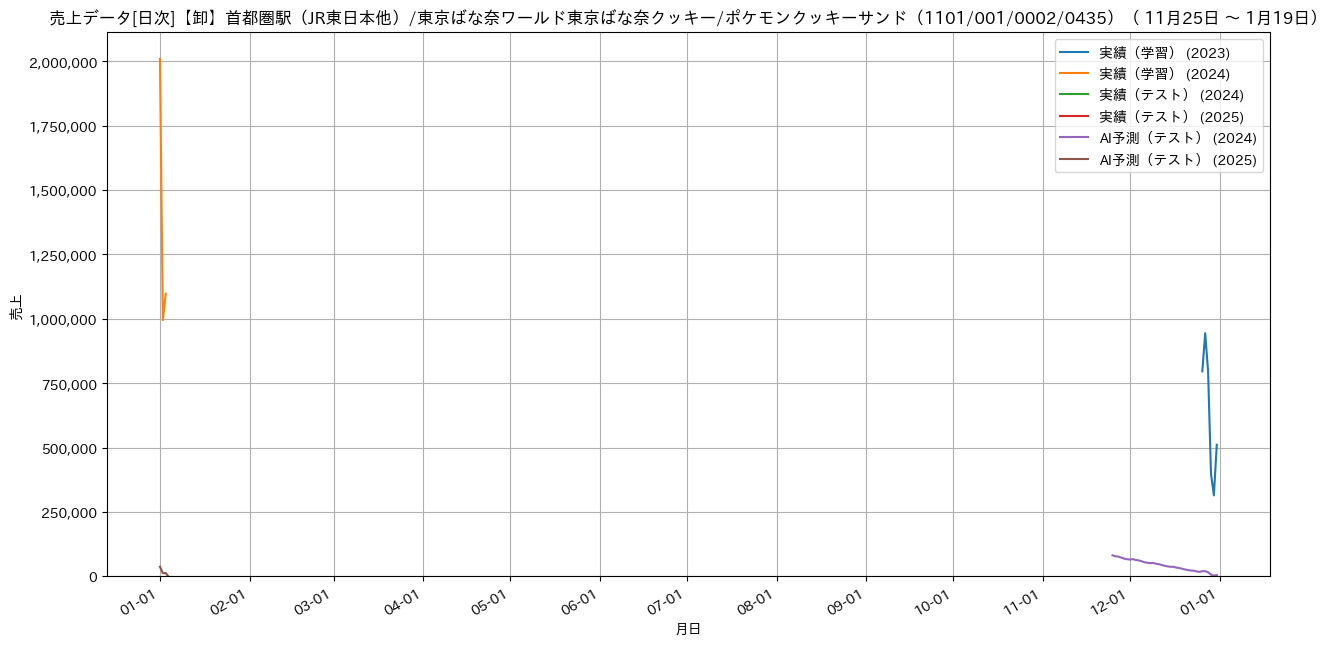

In [312]:
TITLE="【卸】首都圏駅（JR東日本他）/東京ばな奈ワールド東京ばな奈クッキー/ポケモンクッキーサンド（1101/001/0002/0435）"
plot_sales([train_val_df["true_sales"], test_df["true_sales"], test_df["forecast"]],
           ["実績（学習）","実績（テスト）", "AI予測（テスト）"]
          ,start_month_day="11-25", end_month_day="1-19", y_bottom=0, title="売上データ[日次]"+TITLE, pdf_filename="sales.pdf")

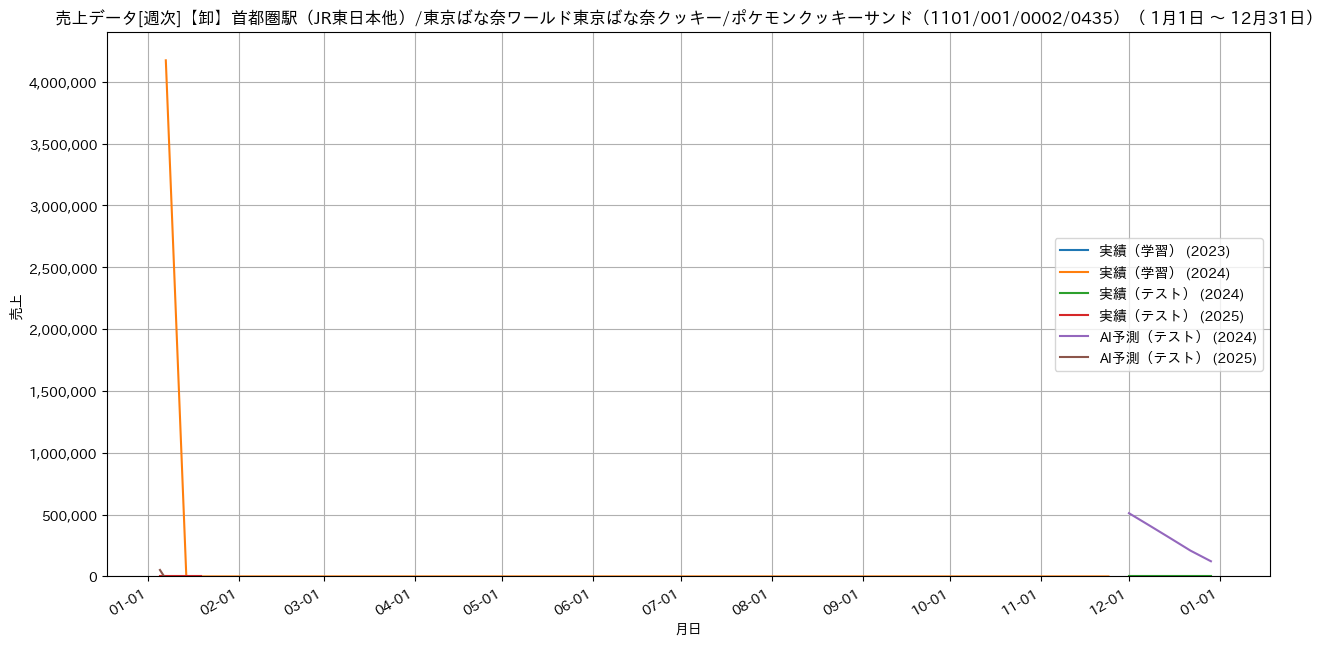

In [313]:
plot_sales([train_val_df["true_sales"].resample("W").sum(), test_df["true_sales"].resample("W").sum(), test_df["forecast"].resample("W").sum()],
           ["実績（学習）","実績（テスト）", "AI予測（テスト）"]
          ,start_month_day="01-01", end_month_day="12-31", y_bottom=0, title="売上データ[週次]"+TITLE, pdf_filename="sales.pdf")

In [29]:
recent_df = pd.read_excel('AI需要予測送付用 (9).xlsx', sheet_name='Sheet1')

In [384]:
import pandas as pd
import numpy as np
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Ensure columns are correctly formatted
recent_df.columns = recent_df.columns.astype(str)  # Convert column names to string if needed

product_columns = recent_df.columns[1:]  # Select specific product columns

all_predictions = {}  # Store predictions for each product
all_errors = {}  # Store errors for each product

for col in product_columns:
    # Convert column name to integer index
    sales_col_index = recent_df.columns.get_loc(col)

    df = recent_df.iloc[9:, [0, sales_col_index]]  # Extract data starting from row 10
    df_header = recent_df.iloc[:9, [0, sales_col_index]]  # Extract original header (first 9 rows)

    df.columns = ["date", "sales"]
    df["date"] = pd.to_datetime(df["date"])
    df["sales"] = pd.to_numeric(df["sales"])

    # Set date as index (for moving average calculations)
    df.set_index("date", inplace=True)

    # Handle missing values
    first_valid_idx = df["sales"].first_valid_index()
    df = df.loc[first_valid_idx:]
    df["true_sales"] = pd.to_numeric(df["sales"], errors="coerce")
    df["sales"] = df["sales"].interpolate(method="linear", limit_direction="both")

    # Step 2: Compute sales duration per product
    train_end_date = df.index.max()
    sales_duration = (train_end_date - df.index.min()).days

    # Step 3: Identify products sold within the last year
    one_year_ago = train_end_date - pd.DateOffset(days=365)
    sales_last_year = df[(df["sales"] > 0) & (df.index >= one_year_ago)].shape[0]

    # Step 4: Exclude new products (sold < 1 year but had sales last year)
    if sales_duration < 365 and sales_last_year > 0:
        print(f"Skipping new product: {col}")
        continue  # Skip to the next product

    # Step 5: Run Forecasting
    train_df, val_df, test_df, train_val_df = main_flow_with_dow(df, 30)

    # Step 6: Compute Error
    error, _, _ = calculate_normalized_absolute_error(
        test_df["true_sales"],
        test_df["forecast"],
        freq="W",
        start_date=test_df.index[0]
    )

    all_predictions[col] = test_df["forecast"]
    all_errors[col] = error

# Step 7: Save Predictions and Errors to Excel
output_filename = "predictions.xlsx"
predictions_df = pd.DataFrame(all_predictions)

# Restore original header for selected products
df_header.columns = ["date"] + list(product_columns)
predictions_df = pd.concat([df_header, predictions_df], axis=0)  # Append header

errors_df = pd.DataFrame(list(all_errors.items()), columns=["Product", "Error"])

with pd.ExcelWriter(output_filename) as writer:
    predictions_df.to_excel(writer, sheet_name="Predictions", index=False)  # Keep headers
    errors_df.to_excel(writer, sheet_name="Errors", index=False)

print(f"Predictions and errors saved to {output_filename}")


validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model: 0.0
validation: nae_advanced_yoy: 0.0
validation: nae_two_model

ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required by RandomForestRegressor.

In [300]:
# # ---- 曜日関連の特徴量を計算 ----
# df = calculate_iso_calendar_features(df)
# # ---- 週ごとの売上合計と ratio_in_week を学習データから計算 ----
# df, ratio_by_dow = calculate_weekly_sales_and_ratio(df, sales_column="sales")
# # ---- 曜日効果を削除 (sales_deseason の計算) ----
# df = apply_dow_effect(
#     df, ratio_by_dow, action="remove", sales_column="sales", new_column="sales_deseason"
# )

In [301]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor
# from datetime import timedelta

# # ----------------------------------------------------------------
# # 2. ターゲット変数 (前年同日比の成長率) の作成
# # ----------------------------------------------------------------
# # sales(t-365) が存在する範囲で計算
# df["sales_last_year"] = df["sales_deseason"].shift(365)
# df["growth"] = (df["sales_deseason"] - df["sales_last_year"]) / df["sales_last_year"]

# # ----------------------------------------------------------------
# # 3. 特徴量作成関数の定義
# #    例として、「直近1週間」「その前の1週間」などまとめて計算
# # ----------------------------------------------------------------

# def calc_period_growth(df, current_date, days_length):
#     """
#     df: salesを格納したDF (index = 日付)
#     current_date: 特徴量を計算したい日 (Timestamp)
#     days_length: 期間の長さ (例: 7日, 30日, 180日など)
    
#     戻り値:
#        直近 `days_length` 日間の売上合計 vs その1年前の合計 の成長率
#     """
#     start_date = current_date - timedelta(days=days_length)
#     # 直近 days_length 日の合計
#     recent_sum = df.loc[start_date:current_date - timedelta(days=1), "sales_deseason"].sum()
    
#     # ちょうど1年前の同期間
#     last_year_start = start_date - timedelta(days=365)
#     last_year_end = (current_date - timedelta(days=1)) - timedelta(days=365)
#     last_year_sum = df.loc[last_year_start:last_year_end, "sales_deseason"].sum()

#     if pd.isna(recent_sum) or pd.isna(last_year_sum) or last_year_sum == 0:
#         return np.nan
#     return (recent_sum - last_year_sum) / last_year_sum


# def make_features_for_date(df, current_date):
#     """
#     current_date 当日に必要な特徴量をまとめて計算し、Series で返すイメージ
#     質問にある
#       - 直近1週間
#       - その前の1週間
#       - その前の1週間
#       - 直近1ヶ月
#       - その前の1ヶ月
#       - 直近半年
#       - その前の半年
#     をすべて計算 (例)
#     """
#     features = {}
    
#     # 直近1週間の成長率
#     features["feat_week1"] = calc_period_growth(df, current_date, 7)
    
#     # その前の1週間
#     features["feat_week2"] = calc_period_growth(df, current_date - timedelta(days=7), 7)
    
#     # さらにその前の1週間
#     features["feat_week3"] = calc_period_growth(df, current_date - timedelta(days=14), 7)
    
#     # 直近1ヶ月(30日と仮定)
#     features["feat_month1"] = calc_period_growth(df, current_date, 30)
    
#     # その前の1ヶ月(30日)
#     features["feat_month2"] = calc_period_growth(df, current_date - timedelta(days=30), 30)
    
#     # 直近半年(180日と仮定)
#     features["feat_halfyear1"] = calc_period_growth(df, current_date, 180)
    
#     # その前の半年(180日)
#     features["feat_halfyear2"] = calc_period_growth(df, current_date - timedelta(days=180), 180)
    
#     return pd.Series(features)

# # ----------------------------------------------------------------
# # 4. 学習データセットの作成
# # ----------------------------------------------------------------
# # 学習用に、各日付について特徴量をまとめて作成する
# features_list = []
# targets_list = []
# dates_list = []

# for current_date in df.index:
#     # current_date をターゲットにするときに特徴量計算できるかをチェック
#     # 365日ずらした計算が必要なので、データが欠けないようにする
#     # (ここではあまり厳密にやらないで簡単に例示)
    
#     # 特徴量を作る
#     feat = make_features_for_date(df, current_date)
#     if feat.isna().any():
#         continue  # 欠損があればスキップ(単純化のため)
    
#     # ターゲット (growth)
#     target_val = df.loc[current_date, "growth"]
#     if pd.isna(target_val):
#         continue
    
#     features_list.append(feat.values)
#     targets_list.append(target_val)
#     dates_list.append(current_date)

# X = pd.DataFrame(features_list, columns=feat.index, index=dates_list)
# y = pd.Series(targets_list, index=dates_list, name="growth")

# # ----------------------------------------------------------------
# # 5. 学習データ・テストデータ分割
# #    (最後の2ヶ月をテストデータとする)
# # ----------------------------------------------------------------
# test_start_date = "2024-09-26"  # 質問例から設定
# X_train = X.loc[X.index < test_start_date]
# y_train = y.loc[y.index < test_start_date]

# X_test = X.loc[X.index >= test_start_date]
# y_test = y.loc[y.index >= test_start_date]

# # ----------------------------------------------------------------
# # 6. モデル学習
# # ----------------------------------------------------------------
# model = RandomForestRegressor(n_estimators=100, random_state=0)
# model.fit(X_train, y_train)

# # ----------------------------------------------------------------
# # 7. テスト期間の再帰的予測
# # ----------------------------------------------------------------
# # テスト開始日から最終日まで、1日ずつ予測 -> 売上予測 -> それを踏まえて翌日の特徴量を計算
# start_date_dt = pd.to_datetime(test_start_date)
# end_date_dt   = X_test.index.max()  # 2024-11-25 付近

# # 売上を格納する新たな DataFrameを用意 (実績売上 + 予測売上)
# df_forecast = df.copy()

# current_date = start_date_dt
# while current_date <= end_date_dt:
#     # まずは (current_date) に対応する特徴量を再計算 (最新の予測結果を反映させる)
#     feat = make_features_for_date(df_forecast, current_date)
    
#     if feat.isna().any():
#         # 特徴量が NaN の場合は予測不可 -> スキップ (またはゼロ埋めなど対処)
#         current_date += timedelta(days=1)
#         continue
    
#     # 学習済モデルで成長率を予測
#     growth_pred = model.predict([feat.values])[0]  # 予測した成長率
    
#     # 前年同日 (current_date - 365日) の売上
#     last_year_sales = df_forecast.loc[current_date - timedelta(days=365), "sales_deseason"]
#     # 当日売上予測
#     predicted_sales = last_year_sales * (1 + growth_pred)
    
#     # df_forecast に書き込み
#     df_forecast.loc[current_date, "sales_deseason"] = predicted_sales
    
#     current_date += timedelta(days=1)

# # ----------------------------------------------------------------
# # 8. 結果の評価
# # ----------------------------------------------------------------
# # df_forecast のテスト期間の sales (予測値) と 実績値 (dfに元々ある値) を比較して評価
# # (実際の実装では別途RMSEやMAPEを計算するなど)
# test_dates = pd.date_range(start_date_dt, end_date_dt)
# predicted = df_forecast.loc[test_dates, "sales_deseason"]
# test_df = apply_dow_effect(
#         df_forecast.loc[test_dates], ratio_by_dow, action="apply", sales_column="sales_deseason", new_column="forecast"
#     )
# actual = df.loc[test_dates, "sales"]

# comparison_df = pd.DataFrame({
#     "actual": actual,
#     "predicted": predicted
# })
# print(comparison_df)


In [302]:
mean_absolute_percentage_error(test_df["forecast"], 
                               actual, 
                               freq='W', 
                               start_date=test_df.index[0])

In [ ]:
plot_sales([actual, test_df["forecast"]],
           ["sales", "forcast"]
          ,start_month_day="09-01", end_month_day="12-31")

In [ ]:
df_forecast

In [ ]:
# train_df, val_df, test_df, ensemble = main_flow_with_dow(df,0)
train_df, val_df, test_df= main_flow_with_dow(df)

In [ ]:
mean_absolute_percentage_error(test_df["sales"], test_df["forecast"], freq='D', start_date=test_df.index[0])

In [ ]:
# Call the function
plot_sales([test_df["sales"], test_df["forecast"]],
           ["sales", "forcast"]
          ,start_month_day="09-01", end_month_day="12-31")